In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

# We get a lot of warnings about slices of copies, these are not meaningful.
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Define our source files
COVID_file = 'COVID_by_County/COVID_by_County.csv'
pop_file = 'popData.csv'
US_county_land_file = 'LND01.csv'
#US_county_vote_file = 'president_county_candidate.csv'
mask_use_file ="https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv"
age_file = 'median age.csv'

# Read the source files into dataframes.
COVID_data = pd.read_csv(COVID_file)
pop_data = pd.read_csv(pop_file)
land_data = pd.read_csv(US_county_land_file)
#vote_data = pd.read_csv(US_county_vote_file)
mask_use = pd.read_csv(mask_use_file)
age_data = pd.read_csv(age_file)

In [7]:
# Rename some of the columns
COVID_data = COVID_data.rename(columns={'countyFIPS':'fips'})
pop_data = pop_data.rename(columns={'FIPS':'fips', 'Poverty Percent':'Poverty_pct'})
land_data = land_data.rename(columns={'STCOU':'fips','LND010190D':'land'})

# We don't need most of this dataframe so we truncate it down.
land_data = land_data[['fips','land']]

# the vote data is stored as a mixture of row and column data so we jump through hoops to make it usable.
#Biden = vote_data[vote_data.candidate == 'Joe Biden']
#Trump = vote_data[vote_data.candidate == 'Donald Trump']
#vote_data = Biden[['state', 'county', 'total_votes']].copy()
#vote_data.rename(columns={'total_votes':'Biden'}, inplace=True)
#vote_data['Trump'] = Trump.total_votes.to_numpy()

# We need some definition that allows us to compare to similar categories.
mask_use['mask_pct'] = mask_use['FREQUENTLY'] + mask_use['ALWAYS']

# merge the vote data into the population data, we can't do this on the main dataframe DF because vote data does not use fips.
# pop_data = pd.merge(pop_data, vote_data, left_on = ['CTYNAME', 'STNAME'], right_on = ['county','state'])
pop_data = pd.merge(pop_data, age_data, left_on = 'fips', right_on = 'fips')

In [8]:
# Merge all the datasets into one main dataframe, DF.  Fioltering down when necessary.
DF = pd.merge(COVID_data, pop_data[['fips', 'age', 'POPESTIMATE2018', 'Poverty_pct']], left_on='fips', right_on='fips')
DF = pd.merge(DF,land_data,  left_on='fips', right_on='fips')
DF = pd.merge(DF, mask_use[['COUNTYFP','mask_pct']], left_on = 'fips', right_on = 'COUNTYFP')

# We need to make sure the poverty data is converted from an object type.
#DF.Poverty_pct = DF.Poverty_pct.astype('float')
#This was fixed
print(DF.Poverty_pct.dtype)

# We don't need NaN entries, they will only cause issues.
DF = DF.dropna()

# write out the dataframe to check.
DF

float64


,Dates,fips,County Name,State,cases,deaths,age,POPESTIMATE2018,Poverty_pct,land,COUNTYFP,mask_pct
0,1/22/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,604.49,1001,0.739
1,1/23/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,604.49,1001,0.739
2,1/24/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,604.49,1001,0.739
3,1/25/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,604.49,1001,0.739
4,1/26/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,604.49,1001,0.739
...,...,...,...,...,...,...,...,...,...,...,...,...
1014215,12/5/2020,56045,Weston County,WY,419,2,42.868341,6924,11.8,2400.13,56045,0.581
1014216,12/6/2020,56045,Weston County,WY,420,2,42.868341,6924,11.8,2400.13,56045,0.581
1014217,12/7/2020,56045,Weston County,WY,422,2,42.868341,6924,11.8,2400.13,56045,0.581
1014218,12/8/2020,56045,Weston County,WY,425,2,42.868341,6924,11.8,2400.13,56045,0.581


In [9]:
# Need to fix some counties that have 0 area in the dataset, data manually found with Google.
DF.land[DF['County Name'] == 'Broomfield County and City'] = 33.55
DF.land[DF['County Name'] == 'Yakutat City and Borough'] = 9463
DF.land[DF['County Name'] == 'Denali Borough'] = 12777
DF.land[DF['County Name'] == 'Skagway Municipality'] = 464
DF.land[DF['County Name'] == 'Wrangell City and Borough'] = 3477

# We create new columns containing per capita data
DF['cases_per_cap'] = DF.cases / DF.POPESTIMATE2018
DF['deaths_per_cap'] = DF.deaths / DF.POPESTIMATE2018
DF['pop_density'] = DF.POPESTIMATE2018 / DF.land
# DF['Biden_per_cap'] = DF.Biden /DF.POPESTIMATE2018
# DF['Trump_per_cap'] = DF.Trump /DF.POPESTIMATE2018
DF

,Dates,fips,County Name,State,cases,deaths,age,POPESTIMATE2018,Poverty_pct,land,COUNTYFP,mask_pct,cases_per_cap,deaths_per_cap,pop_density
0,1/22/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,604.49,1001,0.739,0.000000,0.000000,91.867525
1,1/23/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,604.49,1001,0.739,0.000000,0.000000,91.867525
2,1/24/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,604.49,1001,0.739,0.000000,0.000000,91.867525
3,1/25/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,604.49,1001,0.739,0.000000,0.000000,91.867525
4,1/26/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,604.49,1001,0.739,0.000000,0.000000,91.867525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014215,12/5/2020,56045,Weston County,WY,419,2,42.868341,6924,11.8,2400.13,56045,0.581,0.060514,0.000289,2.884844
1014216,12/6/2020,56045,Weston County,WY,420,2,42.868341,6924,11.8,2400.13,56045,0.581,0.060659,0.000289,2.884844
1014217,12/7/2020,56045,Weston County,WY,422,2,42.868341,6924,11.8,2400.13,56045,0.581,0.060947,0.000289,2.884844
1014218,12/8/2020,56045,Weston County,WY,425,2,42.868341,6924,11.8,2400.13,56045,0.581,0.061381,0.000289,2.884844


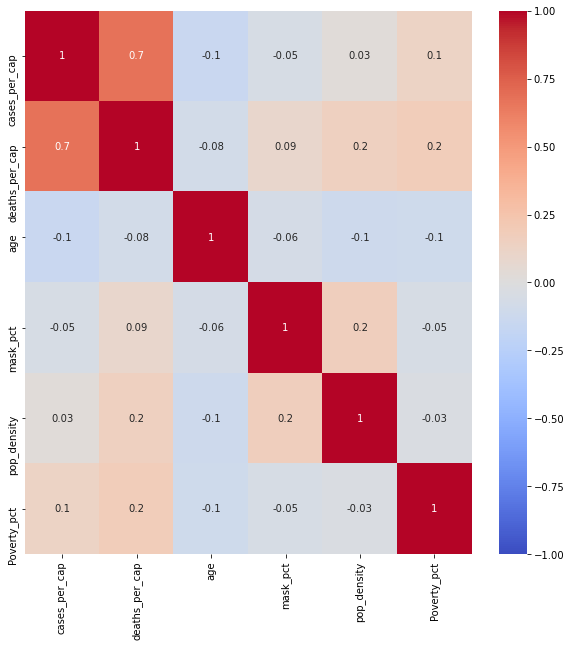

In [10]:
# Print a heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(DF[['cases_per_cap','deaths_per_cap','age','mask_pct','pop_density','Poverty_pct']].corr(), annot = True, fmt = '0.1g', cmap = 'coolwarm', vmin=-1)

In [11]:
# Create some very macabre fits.
deaths_fit = sm.OLS(DF['deaths_per_cap'],sm.add_constant(DF[['Poverty_pct','age','pop_density','mask_pct']])).fit()

print(deaths_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         deaths_per_cap   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                 1.770e+04
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:15:20   Log-Likelihood:             6.3868e+06
No. Observations:             1014220   AIC:                        -1.277e+07
Df Residuals:                 1014215   BIC:                        -1.277e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7.938e-05   6.49e-06     12.235      

In [12]:
cases_fit = sm.OLS(DF['cases_per_cap'],sm.add_constant(DF[['Poverty_pct','age','pop_density','mask_pct']])).fit()

print(cases_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          cases_per_cap   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     9770.
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:15:21   Log-Likelihood:             2.6949e+06
No. Observations:             1014220   AIC:                        -5.390e+06
Df Residuals:                 1014215   BIC:                        -5.390e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0402      0.000    162.781      

In [13]:
# Create a reduced data frame with just one time slice.
RDF = DF[DF['Dates'] == '12/9/2020']
RDF

,Dates,fips,County Name,State,cases,deaths,age,POPESTIMATE2018,Poverty_pct,land,COUNTYFP,mask_pct,cases_per_cap,deaths_per_cap,pop_density
322,12/9/2020,1001,Autauga County,AL,3117,42,39.110204,55533,13.8,604.49,1001,0.739,0.056129,0.000756,91.867525
645,12/9/2020,1003,Baldwin County,AL,10087,141,41.936009,217855,9.8,2027.08,1003,0.759,0.046301,0.000647,107.472325
968,12/9/2020,1005,Barbour County,AL,1245,30,40.922061,24872,30.9,904.59,1005,0.692,0.050056,0.001206,27.495329
1291,12/9/2020,1007,Bibb County,AL,1322,39,40.030723,22367,21.8,625.50,1007,0.850,0.059105,0.001744,35.758593
1614,12/9/2020,1009,Blount County,AL,3496,47,40.258569,57771,13.2,650.65,1009,0.653,0.060515,0.000814,88.789672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012927,12/9/2020,56037,Sweetwater County,WY,2245,13,36.712467,42858,8.4,10491.73,56037,0.414,0.052382,0.000303,4.084932
1013250,12/9/2020,56039,Teton County,WY,1834,2,40.288442,23269,6.3,4221.96,56039,0.587,0.078817,0.000086,5.511421
1013573,12/9/2020,56041,Uinta County,WY,1250,7,37.127559,20292,10.0,2087.66,56041,0.471,0.061601,0.000345,9.719974
1013896,12/9/2020,56043,Washakie County,WY,586,11,42.326714,7877,11.9,2242.85,56043,0.572,0.074394,0.001396,3.512049


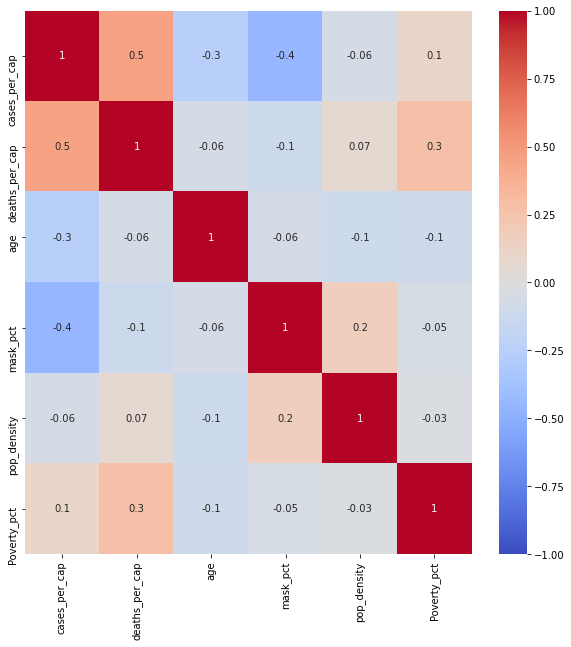

In [14]:
# Print a heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(RDF[['cases_per_cap','deaths_per_cap','age','mask_pct','pop_density','Poverty_pct']].corr(), annot = True, fmt = '0.1g', cmap = 'coolwarm', vmin=-1)
plt.savefig('heatmap_noVote.png', dpi=300)

In [15]:
# Create some very macabre fits.
deaths_fit = sm.OLS(RDF['deaths_per_cap'],sm.add_constant(RDF[['Poverty_pct','pop_density','age','mask_pct']])).fit()

print(deaths_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         deaths_per_cap   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     85.01
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           1.23e-68
Time:                        17:17:46   Log-Likelihood:                 18266.
No. Observations:                3140   AIC:                        -3.652e+04
Df Residuals:                    3135   BIC:                        -3.649e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0011      0.000      5.888      

In [16]:
cases_fit = sm.OLS(RDF['cases_per_cap'],sm.add_constant(RDF[['Poverty_pct','pop_density','age','mask_pct']])).fit()

print(cases_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          cases_per_cap   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     308.0
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          1.02e-223
Time:                        17:17:48   Log-Likelihood:                 7571.3
No. Observations:                3140   AIC:                        -1.513e+04
Df Residuals:                    3135   BIC:                        -1.510e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2017      0.006     35.484      

In [17]:
#We will be predicting Florida data, so pull Florida for test
mask = (RDF['State'] == 'FL')

RDF_train = RDF[~mask]
RDF_test = RDF[mask]

In [18]:
RDF_test

,Dates,fips,County Name,State,cases,deaths,age,POPESTIMATE2018,Poverty_pct,land,COUNTYFP,mask_pct,cases_per_cap,deaths_per_cap,pop_density
103359,12/9/2020,12001,Alachua County,FL,13649,106,36.607553,268851,19.8,969.18,12001,0.921,0.050768,0.000394,277.400483
103682,12/9/2020,12003,Baker County,FL,2135,34,37.779014,28353,15.4,588.92,12003,0.657,0.075301,0.001199,48.144060
104005,12/9/2020,12005,Bay County,FL,9344,177,41.107581,186240,13.4,1033.35,12005,0.750,0.050172,0.000950,180.229351
104328,12/9/2020,12007,Bradford County,FL,1501,19,40.528776,27752,19.5,300.06,12007,0.554,0.054086,0.000685,92.488169
104651,12/9/2020,12009,Brevard County,FL,17077,464,44.552380,595203,11.0,1557.25,12009,0.764,0.028691,0.000780,382.214160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123385,12/9/2020,12125,Union County,FL,1279,61,39.723633,15328,20.6,249.72,12125,0.740,0.083442,0.003980,61.380746
123708,12/9/2020,12127,Volusia County,FL,17875,386,44.447658,546101,13.2,1432.51,12127,0.810,0.032732,0.000707,381.219677
124031,12/9/2020,12129,Wakulla County,FL,1752,18,40.102344,32413,11.9,735.78,12129,0.704,0.054052,0.000555,44.052570
124354,12/9/2020,12131,Walton County,FL,4000,39,42.270281,70732,11.4,1238.13,12131,0.756,0.056551,0.000551,57.128088


In [19]:
#results for cases and deaths per capita are separate
X_train = RDF_train[['Poverty_pct','pop_density','age','mask_pct']]
y_cases_train = RDF_train['cases_per_cap']
y_deaths_train = RDF_train['deaths_per_cap']

X_test = RDF_test[['Poverty_pct','pop_density','age','mask_pct']]
y_cases_test = RDF_test['cases_per_cap']
y_deaths_test = RDF_test['deaths_per_cap']

In [20]:
#Cross-validation for deaths random forest
d_range = np.arange(1, 14)
dd_scores = []
for d in d_range:
    rf = RandomForestRegressor(max_depth = d, random_state=440)
    loss = abs(cross_val_score(rf, X_train, y_deaths_train, cv=5, scoring='neg_mean_squared_error'))
    dd_scores.append(loss.mean())

dmin = min(dd_scores)
deaths_depth = d_range[dd_scores == min(dd_scores)][0]

#Cross-validation for cases random forest
d_scores = []
for d in d_range:
    rf = RandomForestRegressor(max_depth = d, random_state=440)
    loss = abs(cross_val_score(rf, X_train, y_cases_train, cv=5, scoring='neg_mean_squared_error'))
    d_scores.append(loss.mean())

cases_depth = d_range[d_scores == min(d_scores)][0]

In [21]:
print('Cases smallest error: ' + str(min(d_scores)) + ' at a forest depth of ' + str(cases_depth))
print('Deaths smallest error: ' + str(dmin) + ' at a forest depth of ' + str(deaths_depth))

Cases smallest error: 0.0004707987060078033 at a forest depth of 6
Deaths smallest error: 5.523797022820049e-07 at a forest depth of 3


In [22]:
#Fit random forest regressor for cases at max_depth at cases_depth
regr_c = RandomForestRegressor(max_depth = cases_depth, random_state=440)
regr_c.fit(X_train, y_cases_train)

#Fit random forest regressor for deaths at max_depth at deaths_depth
regr_d = RandomForestRegressor(max_depth = deaths_depth, random_state=440)
regr_d.fit(X_train, y_deaths_train)

RandomForestRegressor(max_depth=3, random_state=440)

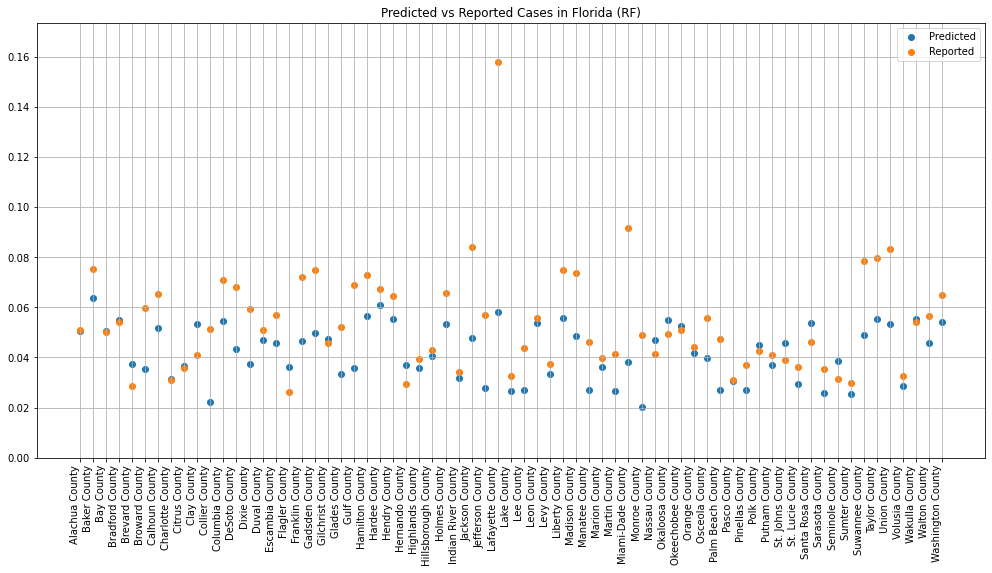

In [23]:
#plot predictions for cases (Random Forest)
fix, ax = plt.subplots(1,1, figsize=(17,8))

plt.title("Predicted vs Reported Cases in Florida (RF)")
pred_c_rf = regr_c.predict(X_test)

ax.scatter(RDF_test['County Name'], pred_c_rf, label = 'Predicted')
ax.scatter(RDF_test['County Name'], y_cases_test, label = 'Reported')
ax.legend()
ax.grid(True)
ax.set_ylim(0,max(y_cases_test)*1.1)

ax.set_xticklabels(RDF_test['County Name'], rotation=90, ha='right');

In [24]:
print('Mean reported is ' + str(np.mean(y_cases_test)))
print('Mean predicted is ' + str(np.mean(pred_c_rf)))
print('Mean error is ' + str(np.mean(y_cases_test - pred_c_rf)))

print('\n')
print('This is a predicted difference of ' + str(int(np.mean(y_cases_test - pred_c_rf) * RDF.POPESTIMATE2018[mask].sum())) + ' cases')

Mean reported is 0.05371224886142851
Mean predicted is 0.04218350158379696
Mean error is 0.011528747277631528


This is a predicted difference of 244920 cases


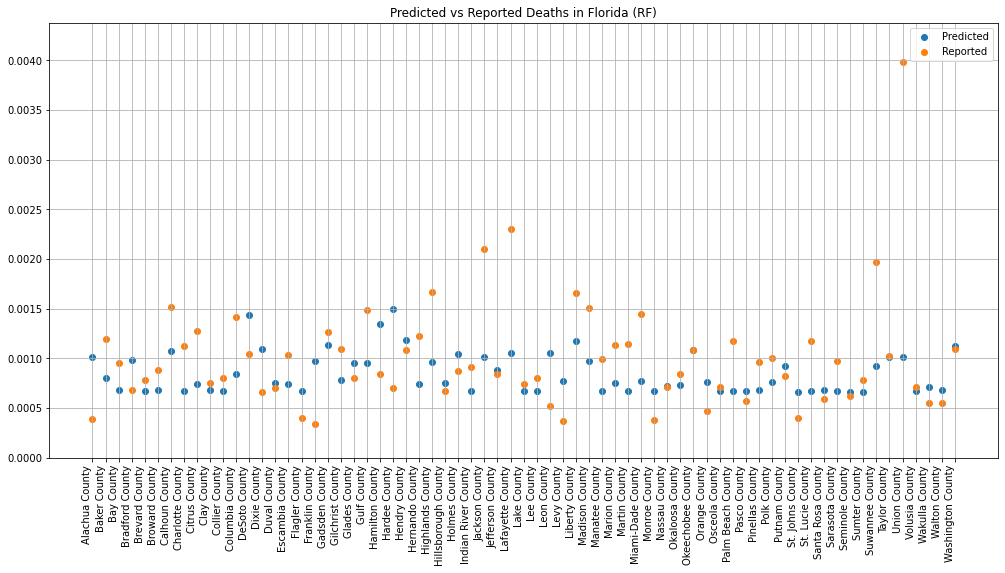

In [28]:
#plot predictions for deaths (Random Forest)
fix, ax = plt.subplots(1,1, figsize=(17,8))

plt.title("Predicted vs Reported Deaths in Florida (RF)")
pred_d_rf = regr_d.predict(X_test)

ax.scatter(RDF_test['County Name'], pred_d_rf, label = 'Predicted')
ax.scatter(RDF_test['County Name'], y_deaths_test, label = 'Reported')
ax.legend()
ax.grid(True)
ax.set_ylim(0,max(y_deaths_test)*1.1)
ax.set_xticklabels(RDF_test['County Name'], rotation=90, ha='right');

In [26]:
print('Mean reported is ' + str(np.mean(y_deaths_test)))
print('Mean predicted is ' + str(np.mean(pred_d_rf)))
print('Mean error is ' + str(np.mean(y_deaths_test - pred_d_rf)))
print('\n')
print('This is a predicted difference of ' + str(int(np.mean(y_deaths_test -pred_d_rf) * RDF.POPESTIMATE2018[mask].sum())) + ' deaths')

Mean reported is 0.0010042040369803214
Mean predicted is 0.0008487752325431825
Mean error is 0.000155428804437139


This is a predicted difference of 3301 deaths


In [27]:
#Cross-validation for cases KNeighbors Regressor
k_range = np.arange(1, 91)
k_scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    loss = abs(cross_val_score(knn, X_train, y_cases_train, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())

kmin = min(k_scores)
cases_nn = k_range[k_scores == min(k_scores)][0]    

#Cross-validation for deaths KNeighbors Regressor
dk_scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    loss = abs(cross_val_score(knn, X_train, y_deaths_train, cv=5, scoring='neg_mean_squared_error'))
    dk_scores.append(loss.mean())

deaths_nn = k_range[dk_scores == min(dk_scores)][0]    

In [29]:
print('Cases smallest error: ' + str(kmin) + ' at ' + str(cases_nn) + ' nearest neighbors.')
print('Deaths smallest error: ' + str(min(dk_scores)) + ' at ' + str(deaths_nn) + ' nearest neighbors.')

Cases smallest error: 0.0005932126380175742 at 29 nearest neighbors.
Deaths smallest error: 5.584283911993534e-07 at 87 nearest neighbors.


In [30]:
#Fit KNeighbors Regressor for Cases and Deaths
knn_c = KNeighborsRegressor(n_neighbors=cases_nn)
knn_d = KNeighborsRegressor(n_neighbors=deaths_nn)

knn_c.fit(X_train, y_cases_train)
knn_d.fit(X_train, y_deaths_train)

KNeighborsRegressor(n_neighbors=87)

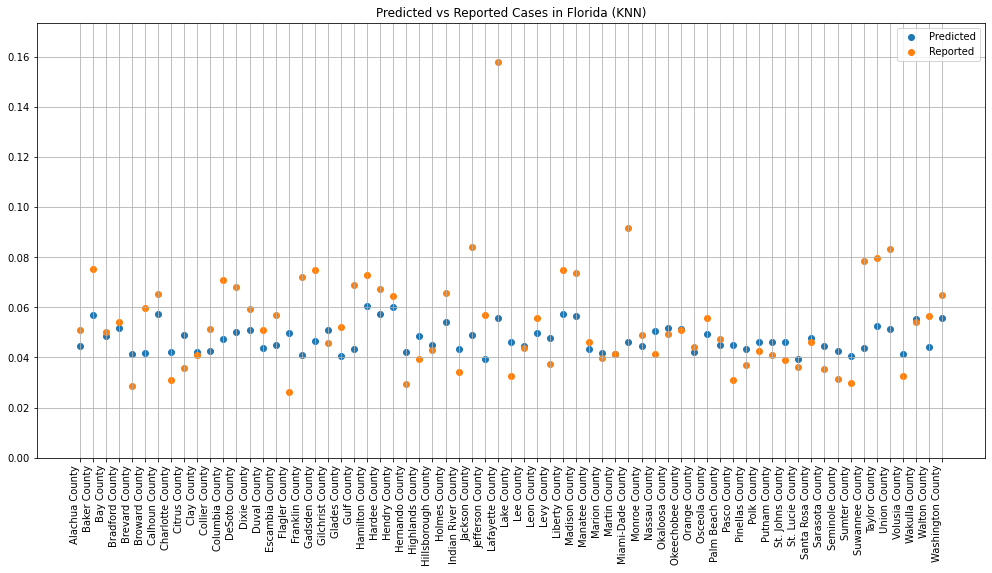

In [31]:
#Plot predicted cases KNN
fix, ax = plt.subplots(1,1, figsize=(17,8))

plt.title("Predicted vs Reported Cases in Florida (KNN)")
pred_c_knn = knn_c.predict(X_test)

ax.scatter(RDF_test['County Name'], pred_c_knn, label = 'Predicted')
ax.scatter(RDF_test['County Name'], y_cases_test, label = 'Reported')
ax.legend()
ax.grid(True)
ax.set_ylim(0,max(y_cases_test)*1.1)
ax.set_xticklabels(RDF_test['County Name'], rotation=90, ha='right');

In [32]:
print('Mean reported is ' + str(np.mean(y_deaths_test)))
print('Mean predicted is ' + str(np.mean(pred_c_knn)))
print('Mean error is ' + str(np.mean(y_cases_test - pred_c_knn)))
print('\n')
print('This is a predicted difference of ' + str(int(np.mean(y_cases_test - pred_c_knn) * RDF.POPESTIMATE2018[mask].sum())) + ' cases')

Mean reported is 0.0010042040369803214
Mean predicted is 0.04743546486804817
Mean error is 0.006276783993380314


This is a predicted difference of 133345 cases


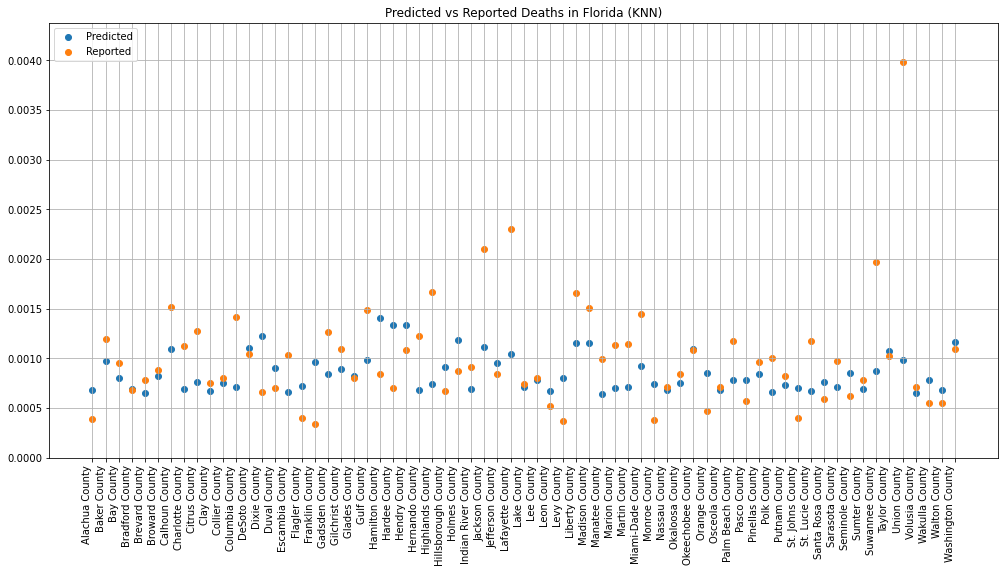

In [33]:
#Plot predicted cases KNN
fix, ax = plt.subplots(1,1, figsize=(17,8))

plt.title("Predicted vs Reported Deaths in Florida (KNN)")

pred_d_knn = knn_d.predict(X_test)

ax.scatter(RDF_test['County Name'], pred_d_knn, label = 'Predicted')
ax.scatter(RDF_test['County Name'], y_deaths_test, label = 'Reported')
ax.legend(loc = 'upper left')
ax.grid(True)
ax.set_ylim(0,max(y_deaths_test)*1.1)
ax.set_xticklabels(RDF_test['County Name'], rotation=90, ha='right');

In [34]:
print('Mean reported is ' + str(np.mean(y_deaths_test)))
print('Mean predicted is ' + str(np.mean(pred_d_knn)))
print('Mean error is ' + str(np.mean(y_deaths_test - pred_d_knn)))
print('\n')
print('This is a predicted difference of ' + str(int(np.mean(y_deaths_test - pred_d_knn) * RDF.POPESTIMATE2018[mask].sum())) + ' deaths')

Mean reported is 0.0010042040369803214
Mean predicted is 0.00085482538432831
Mean error is 0.00014937865265201146


This is a predicted difference of 3173 deaths
